In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import os
import sys
from tqdm import tqdm

sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')
sys.path.append('code')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
import pandas as pd
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
import csv_utils
import segmentation
import feature_extraction

In [3]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

iEEG_filename = "HUP172_phaseII"
start_time_usec = 402580 * 1e6
stop_time_usec = 402800 * 1e6
electrodes = ["LE10", "LE11", "LH01", "LH02", "LH03", "LH04"]

In [4]:
data, fs = get_iEEG_data(username, password, iEEG_filename, start_time_usec, stop_time_usec,
                         select_electrodes=electrodes)
t_sec = np.linspace(start_time_usec, stop_time_usec, num=data.shape[0]) / 1e6

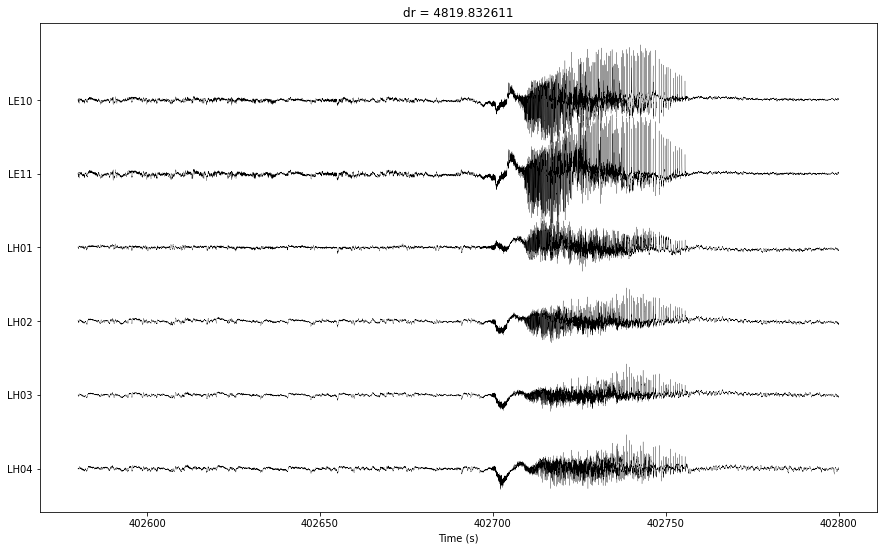

In [5]:
plot_iEEG_data(data, t_sec)

Text(0.5, 0, 'Clip Time (sec)')

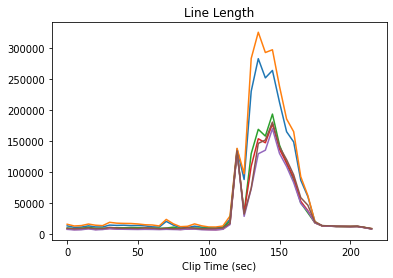

In [6]:
win_size_sec = 5

win_size_ind = int(win_size_sec * fs)

start_range = np.arange(0, len(data), win_size_ind, dtype=int)

ll_arr = np.zeros((len(start_range), data.shape[1]))
for i, start_ind in enumerate(start_range):
    ll_arr[i] = line_length(data[start_ind:(start_ind + win_size_ind)])

fig, ax = plt.subplots()
ax.plot(start_range / fs, ll_arr)
ax.set_title("Line Length")
ax.set_xlabel("Clip Time (sec)")

In [7]:
metadata = pd.read_csv('ieeg_metadata.csv')
metadata.describe()

,Unnamed: 0,Seizure number,Seizure EEC,Seizure UEO,Seizure end,Seizure duration
count,256.000000,256.000000,2.560000e+02,2.560000e+02,2.560000e+02,256.000000
mean,161.523438,3.808594,3.850046e+05,3.850087e+05,3.850987e+05,89.983726
std,105.468253,4.411047,2.512188e+05,2.512184e+05,2.512276e+05,107.030035
min,0.000000,0.000000,1.422600e+04,1.422600e+04,1.425995e+04,4.900000
25%,64.750000,1.000000,2.076900e+05,2.076916e+05,2.077277e+05,34.252500
50%,155.500000,2.000000,3.487700e+05,3.487708e+05,3.490025e+05,67.945000
75%,255.250000,5.000000,5.301436e+05,5.301436e+05,5.302733e+05,91.760000
max,364.000000,22.000000,1.694568e+06,1.694570e+06,1.694644e+06,781.950000


In [45]:
seizure_data = csv_utils.read_pickle('data/seizure/seizure_clips_data', 30)
seizure_time = csv_utils.read_pickle('data/seizure_time/seizure_time_data', 30)
for i in range(len(seizure_data)):
    seizure_data[i] = seizure_data[i].dropna(axis='columns')

In [9]:
nonseizure_data = csv_utils.read_pickle('data/non_seizure/nonseizure_clips_data', 30)
nonseizure_time = csv_utils.read_pickle('data/non_seizure_time/nonseizure_time_data', 30)
for i in range(len(nonseizure_data)):
    nonseizure_data[i] = nonseizure_data[i].dropna(axis='columns')

In [10]:
# seizure_data,seizure_time = csv_utils.seizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(seizure_data,'data/seizure/seizure_clips_data')
# csv_utils.dump_pickle(seizure_time,'data/seizure_time/seizure_time_data')

In [11]:
# nonseizure_data, nonseizure_time = csv_utils.nonseizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(nonseizure_data,'data/non_seizure/nonseizure_clips_data')
# csv_utils.dump_pickle(nonseizure_time,'data/non_seizure_time/nonseizure_time_data')

In [47]:
window_len = 2
stride = 1
seizure_data_windowed = []
for i in tqdm(range(len(seizure_data))):
    fs = segmentation.get_fs(seizure_time[i])
    seg = segmentation.get_windoweds(seizure_data[i].to_numpy(), fs, window_len, stride)
    seizure_data_windowed.append(seg)

100%|██████████| 30/30 [00:00<00:00, 46.81it/s]


In [63]:
seizure_data_features = []
for i, clip in tqdm(enumerate(seizure_data_windowed)):
    fs = segmentation.get_fs(seizure_time[i])
    f1 = feature_extraction.calculate_line_length(clip)
    f2 = feature_extraction.calculate_area(clip)
    f3 = feature_extraction.calculate_energy(clip)
    f4 = feature_extraction.avg_frequency_mag(clip)
    f5 = feature_extraction.hjorthActivity(clip)
    f6 = feature_extraction.hjorthComplexity(clip)
    f7 = feature_extraction.hjorthMobility(clip)
    f8 = np.transpose(feature_extraction.freqFeatures(clip, fs=fs), [1, 0, 2])
    f = np.array([f1, f2, f3, f4])
    f = np.vstack((f, f8))
    f = np.transpose(f,[1,2,0])
    f_exam = f
    if np.isinf(f_exam).any() or np.isnan(f_exam).any():
        print('nan of inf')
    seizure_data_features.append(f)

12it [00:14,  1.06s/it]code\feature_extraction.py:142: RuntimeWarning: invalid value encountered in true_divide
  q = var_gred / var
30it [00:25,  1.20it/s]


In [67]:
seizure_data_features_flatten = []
for i, clip in enumerate(seizure_data_features):
    seizure_data_features_flatten.append(clip.reshape((clip.shape[0]*clip.shape[1], clip.shape[2])))

In [69]:

pca = PCA()
seizure_reduced = pca.fit_transform()

(11564, 11)